In [1]:
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar
from scipy.integrate import quad
import sympy as smp
from scipy.integrate import solve_ivp
from scipy.optimize import root_scalar
from constants import *
from magnetic_field_script import magnetic_field_bar, magnetic_field_gradient

This is the magnetisation method, it is in a method to allow for change along the beam for different magnetisation in the future. For example dual magnetisation in opposite directions.

In [ ]:
def m_line_of_s(s): 
    return 8e3

We define the symbolic sunction and variables which help to analytically derive the expressions for beam bending. The rotation matrix of phi is around the x axis and this projects the bending into 3D. THe bending around the z axis is dependant on theta and therefore is the bending of the beam.

In [3]:
s_sym, theta_sym = smp.symbols('s theta', real=True)
Bx_sym, By_sym, Bz_sym = smp.symbols('Bx By Bz', real=True)
gBx_sym, gBy_sym, gBz_sym = smp.symbols('gBx gBy gBz', real=True)
m1, m2, m3 = smp.symbols('m1 m2 m3', real=True)
theta = theta_sym  

B_vec  = smp.Matrix([Bx_sym, By_sym, Bz_sym])
Bg_vec = smp.Matrix([gBx_sym, gBy_sym, gBz_sym])
m_vec  = smp.Matrix([m1, m2, m3])


R = smp.Matrix([[smp.cos(theta_sym), -smp.sin(theta_sym), 0],
                [smp.sin(theta_sym),  smp.cos(theta_sym), 0],
                [0,                   0,                  1]])
dR_dtheta = R.diff(theta_sym)
dR_dtheta_m = dR_dtheta * m_vec  

t_hat  = smp.Matrix([smp.cos(theta_sym), smp.sin(theta_sym), 0])
x_vec  = s_sym * t_hat    
dx_dtheta = x_vec.diff(theta_sym)
print(dR_dtheta_m)
print(dx_dtheta)
inner_integrand_scalar = (dR_dtheta_m.T @ B_vec)[0] + (dx_dtheta.T @ Bg_vec)[0]

f_scalar_sym = smp.lambdify(
    (s_sym, theta_sym, Bx_sym, By_sym, Bz_sym, gBx_sym, gBy_sym, gBz_sym, m1, m2, m3),
    inner_integrand_scalar, modules='numpy'
)
df_dtheta_fn = smp.lambdify(
    (s_sym, theta_sym, Bx_sym, By_sym, Bz_sym, gBx_sym, gBy_sym, gBz_sym, m1, m2, m3),
    smp.diff(inner_integrand_scalar, theta_sym), modules='numpy'
)
df_dBx_fn = smp.lambdify(
    (s_sym, theta_sym, Bx_sym, By_sym, Bz_sym, gBx_sym, gBy_sym, gBz_sym, m1, m2, m3),
    smp.diff(inner_integrand_scalar, Bx_sym), modules='numpy'
)
df_dBy_fn = smp.lambdify(
    (s_sym, theta_sym, Bx_sym, By_sym, Bz_sym, gBx_sym, gBy_sym, gBz_sym, m1, m2, m3),
    smp.diff(inner_integrand_scalar, By_sym), modules='numpy'
)
df_dBz_fn = smp.lambdify(
    (s_sym, theta_sym, Bx_sym, By_sym, Bz_sym, gBx_sym, gBy_sym, gBz_sym, m1, m2, m3),
    smp.diff(inner_integrand_scalar, Bz_sym), modules='numpy'
)
df_dgBx_fn = smp.lambdify(
    (s_sym, theta_sym, Bx_sym, By_sym, Bz_sym, gBx_sym, gBy_sym, gBz_sym, m1, m2, m3),
    smp.diff(inner_integrand_scalar, gBx_sym), modules='numpy'
)
df_dgBy_fn = smp.lambdify(
    (s_sym, theta_sym, Bx_sym, By_sym, Bz_sym, gBx_sym, gBy_sym, gBz_sym, m1, m2, m3),
    smp.diff(inner_integrand_scalar, gBy_sym), modules='numpy'
)
df_dgBz_fn = smp.lambdify(
    (s_sym, theta_sym, Bx_sym, By_sym, Bz_sym, gBx_sym, gBy_sym, gBz_sym, m1, m2, m3),
    smp.diff(inner_integrand_scalar, gBz_sym), modules='numpy'
)


Matrix([[-m1*sin(theta) - m2*cos(theta)], [m1*cos(theta) - m2*sin(theta)], [0]])
Matrix([[-s*sin(theta)], [s*cos(theta)], [0]])


We define the fucniton to solve the beam bending using forward kinematics. The magnetic field and gradient are computed at each s along the beam to allow for accurate spatial bending. This produces a higher magnitude of bending in attraction mode because the gradient and torque initially increases as the tip of the beam moces closer to the EPM.

THe shooting method is used which guess' values of the initial bending and integrates until the boundary condition is met of 0 bending at the tip. If a root is found then Brent method of root finder is applied because it is guarenteed to converge if there is a root. Where as if there isnt a root where the sign transitions from positive to negative then the secant method is applied which requires 2 different points close.

In [4]:
def simulate_beam(
    p_vec, psi, *,
    L, A_val, E_val, I_val,
    MU0, MAGNET_M,
    m_line_of_s,                
    GRAD_SCALE=1.0,
    s_steps=400,
    k_bounds=(-500.0, 500.0),
    k_grid=81,
    field_at_tip = False
):
    m_ext_dir = np.array([np.cos(psi), np.sin(psi), 0.0], dtype=float)
    m_ext_dir_sec = np.array([np.cos(psi), np.sin(psi), 0.0], dtype=float)

    T0 = np.asarray(magnetic_field_bar(p_vec, MU0, MAGNET_M), float)      # (3,3)
    B0 = T0 @ m_ext_dir_sec
    dB_dr0 = np.asarray(magnetic_field_gradient(p_vec, m_ext_dir, MU0, MAGNET_M), float)  # 3x3

    def field_and_grad_at(p_now):
        T = np.asarray(magnetic_field_bar(p_now, MU0, MAGNET_M), float)      # 3x3
        B = T @ m_ext_dir                                                     # (3,)
        dB_dr = np.asarray(magnetic_field_gradient(p_now, m_ext_dir, MU0, MAGNET_M), float)  # 3x3
        return B, dB_dr

    def Bg_components(theta_val: float, s_val: float):
        t_hat = np.array([-np.cos(theta_val), np.sin(theta_val), 0.0], float)
        p_now = p_vec + 1 * s_val * t_hat

        B_now, dB_dr_now = field_and_grad_at(p_now)     

        mL = float(m_line_of_s(s_val))       
        m_body = np.array([mL, 0.0, 0.0])   
        c, s = np.cos(theta_val), np.sin(theta_val)
        Rz = np.array([[c,-s,0.0],[s,c,0.0],[0.0,0.0,1.0]])
        Rm_world = Rz @ m_body                 # R m

        gB_vec = dB_dr_now.T @ Rm_world       
        return B_now, (gB_vec[0], gB_vec[1], gB_vec[2]) , p_now



    def f_scalar(s_val, theta_val):
        B_now, (gBx, gBy, gBz), p_vec_test = Bg_components(theta_val, s_val)
        mL = float(m_line_of_s(s_val))  

        gBx *= (1 *GRAD_SCALE)
        gBy *= (1*GRAD_SCALE)
        gBz *= (1*GRAD_SCALE)

        return float(
            f_scalar_sym(
                float(s_val), float(theta_val),
                float(B_now[0]), float(B_now[1]), float(B_now[2]),
                float(gBx), float(gBy), float(gBz),
                float(mL), 0.0, 0.0   
            )
        )

    def rhs(s, y):
        return np.array([y[1], -(A_val/(E_val*I_val)) * f_scalar(s, y[0])], dtype=float)

    def shoot_residual(k_guess):
        sol = solve_ivp(rhs, (0.0, L), y0=[0.0, float(k_guess)], t_eval=[L], max_step=L/200)
        return float(sol.y[1, -1])

    k_lo, k_hi = k_bounds
    ks = np.linspace(k_lo, k_hi, int(k_grid))
    vals = [shoot_residual(k) for k in ks]
    idx = np.where(np.sign(vals[:-1]) * np.sign(vals[1:]) < 0)[0]
    if len(idx) == 0:
        j = int(np.argmin(np.abs(vals))); k_star = ks[j]
        try:
            k_b = ks[min(j+1, len(ks)-1)]
            res = root_scalar(shoot_residual, x0=k_star, x1=k_b, method='secant')
            if res.converged: k_star = float(res.root)
        except Exception:
            pass
    else:
        k_a, k_b = ks[idx[0]], ks[idx[0]+1]
        res = root_scalar(shoot_residual, bracket=(k_a, k_b), method='brentq')
        k_star = float(res.root) if res.converged else float(0.5*(k_a+k_b))

    s_grid = np.linspace(0.0, L, int(s_steps))
    sol_ivp = solve_ivp(rhs, (0.0, L), y0=[0.0, k_star], t_eval=s_grid, max_step=L/400)
    theta_tip = float(sol_ivp.y[0, -1])

    m_line_base = m_line_of_s(0.0)
    m_line_tip  = m_line_of_s(L)
    B_tip, gB_tip, p_vec_test = Bg_components(theta_tip, L)   

    if field_at_tip == True:
        print(
            f"|B|_base={np.linalg.norm(B0):.3e} T, ||∇B||_base={np.linalg.norm(dB_dr0,'fro'):.3e} T/m, m_line(0)={m_line_base:.3e} A·m\n"
            f"|B|_tip ={np.linalg.norm(B_tip):.3e} T, |gB|_tip={np.linalg.norm(gB_tip):.3e} T/m, m_line(L)={m_line_tip:.3e} A·m at {p_vec_test}"
        )


    info = {
        "B_base": B0, "dB_dr_base": dB_dr0, "T_base": T0,
        "ks": ks, "residuals": np.array(vals), "k_star": k_star,
        "field_and_grad_at": field_and_grad_at,
    }
    return theta_tip, k_star, sol_ivp, info


In [5]:
p_now = np.array([0,0.2,0])
base_dir = np.array([-1,0,0])
m_base = float(1.0) * np.asarray(base_dir, float)
T = magnetic_field_bar(p_now, MU0 ,MAGNET_M)   # 3x3
B_vec = (T @ m_base).ravel() 
B_vec

array([0.00428575, 0.        , 0.        ])

The Jacobian is derived from the simulate beam function. The first for loop is there to provide intution for the magnetic torque, gradient and field at the tip in comparison to the base which is explored further later. The second for loop maps the solution to the a values and b values which allows for linerisaiton of the function with repect to theta and psi.This in principle describes the sensitivity of the rotation of the magnetic field.

In [ ]:
def jacobian_tip_from_sim2(
    p_vec, psi_rad, *,
    L, A_val, E_val, I_val,
    MU0, MAGNET_M,
    m_line_of_s,
    GRAD_SCALE=1.0, s_steps=400,
    h_deg=0.1,
):
    theta_tip, _, sol_ivp, info = simulate_beam(
        p_vec, psi_rad,
        L=LENGTH, A_val=A_val, E_val=E_val, I_val=I_val,
        MU0=MU0, MAGNET_M=MAGNET_M,
        m_line_of_s=m_line_of_s, GRAD_SCALE=GRAD_SCALE, s_steps=s_steps
    )

    s_grid    = sol_ivp.t
    theta_nom = sol_ivp.y[0]
    h         = np.deg2rad(h_deg)

    def m_ext_dir(psi_val):
        return np.array([np.cos(psi_val), np.sin(psi_val), 0.0], float)

    def field_and_grad_at(p_now, psi_val):
        T     = np.asarray(magnetic_field_bar(p_now, MU0, MAGNET_M), float)       
        B_now = T @ m_ext_dir(psi_val)                                             
        dB_dr = np.asarray(magnetic_field_gradient(p_now, m_ext_dir(psi_val), MU0, MAGNET_M), float) 
        return B_now, dB_dr

    def tip_frame_m_world(theta_val, mL):
        c, s = np.cos(theta_val), np.sin(theta_val)
        Rz   = np.array([[c,-s,0.0],[s,c,0.0],[0.0,0.0,1.0]], float)
        return Rz @ np.array([mL, 0.0, 0.0], float)

    B_path, gB_path, dBdpsi_path, p_path = [], [], [], []
    for sv, th in zip(s_grid, theta_nom):
        t_hat = np.array([-np.cos(th), np.sin(th), 0.0], float)
        p_now = p_vec +  sv * t_hat
        p_path.append(p_now)
        B_now, dB_dr_now = field_and_grad_at(p_now, psi_rad)
        # print(f"Magnetic field {B_now}")
        mL      = float(m_line_of_s(sv))
        m_world = tip_frame_m_world(th, mL)

        gB_vec = (dB_dr_now.T @ m_world) * (GRAD_SCALE)
        B_path.append(B_now)
        gB_path.append(gB_vec)

        Bp, _ = field_and_grad_at(p_now, psi_rad + h)
        Bm, _ = field_and_grad_at(p_now, psi_rad - h)
        dBdpsi_path.append((Bp - Bm) / (2.0*h))

    B_path      = np.asarray(B_path, float).reshape(-1, 3)
    gB_path     = np.asarray(gB_path, float).reshape(-1, 3)
    dBdpsi_path = np.asarray(dBdpsi_path, float).reshape(-1, 3)

    def f_scalar_at(sv, th, psi_val):
        t_hat = np.array([-np.cos(th), np.sin(th), 0.0], float)
        p_now = p_vec + sv * t_hat
        B_now, dB_dr_now = field_and_grad_at(p_now, psi_val)
        mL      = float(m_line_of_s(sv))
        m_world = tip_frame_m_world(th, mL)
        gB_vec  = (dB_dr_now.T @ m_world) * (GRAD_SCALE)
        return float(f_scalar_sym(
            float(sv), float(th),
            float(B_now[0]), float(B_now[1]), float(B_now[2]),
            float(gB_vec[0]), float(gB_vec[1]), float(gB_vec[2]),
            float(mL), 0.0, 0.0
        ))

    c = A_val / (E_val * I_val)
    a_vals, b_vals = [], []
    for (sv, th), Bv, p_now in zip(zip(s_grid, theta_nom), B_path, p_path):
        dBv = np.asarray(magnetic_field_gradient(p_now, m_ext_dir(psi_rad), MU0, MAGNET_M), float)
        # print(f"Magnetic field gradient {dBv}")
        mL  = float(m_line_of_s(sv))
        gBv = (dBv.T @ tip_frame_m_world(th, mL)) * (GRAD_SCALE)
        a_here = -c * df_dtheta_fn(sv, th,
                                   float(Bv[0]), float(Bv[1]), float(Bv[2]),
                                   float(gBv[0]), float(gBv[1]), float(gBv[2]),
                                   mL, 0.0, 0.0)

        tau_p = f_scalar_at(sv, th, psi_rad + h)
        tau_m = f_scalar_at(sv, th, psi_rad - h)
        b_here = -c * (tau_p - tau_m) / (2.0*h)

        a_vals.append(a_here)
        b_vals.append(b_here)

    a_vals = np.asarray(a_vals, float)
    b_vals = np.asarray(b_vals, float)

    def a_of(sq): return np.interp(sq, s_grid, a_vals)
    def b_of(sq): return np.interp(sq, s_grid, b_vals)
    def rhs_J1(sq, y): return [y[1], a_of(sq)*y[0] + b_of(sq)]
    def rhs_J2(sq, y): return [y[1], a_of(sq)*y[0]]

    sol_J1 = solve_ivp(rhs_J1, (0.0, L), [0.0, 0.0], t_eval=[L], max_step=L/400)
    sol_J2 = solve_ivp(rhs_J2, (0.0, L), [0.0, 1.0], t_eval=[L], max_step=L/400)

    J1_L, J1p_L = float(sol_J1.y[0, -1]), float(sol_J1.y[1, -1])
    J2_L, J2p_L = float(sol_J2.y[0, -1]), float(sol_J2.y[1, -1])
    J_tip = J1_L + (-J1p_L/J2p_L)*J2_L if abs(J2p_L) > 1e-10 else J1_L

    packed = {
        "a": a_vals, "b": b_vals, "s": s_grid, "sim_info": info,
        "B_path": B_path, "gB_path": gB_path, "dB_dpsi_path": dBdpsi_path,
    }
    return float(theta_tip), float(J_tip), packed


In [13]:
# psi_vals_deg = np.linspace(-360, 360, 20)
psi_vals_rad = np.linspace(-3,3, 50)
# L = L_soft + L_stiff
ys = np.array([0.15, 0.17, 0.19, 0.21, 0.23, 0.25])
# ys = np.array([0.2])
theta_vs_psi = {py: [] for py in ys}
dtheta_dpsi_vs_psi = {py: [] for py in ys}
psi_done = {py: [] for py in ys}

for p_y in ys:
    p_vec = np.array([0.0, p_y, 0.0], float)
    for psi_rad in psi_vals_rad:
        try:
            theta_tip, k_star, sol_ivp, info = simulate_beam(
                p_vec=p_vec,
                psi=psi_rad,
                L=LENGTH,
                A_val=A_val,  
                E_val=E_val,
                I_val=I_val,
                MU0=MU0,
                MAGNET_M=MAGNET_M,
                m_line_of_s=m_line_of_s,
                s_steps=200,
      
            )
        except Exception as e:
            print(f"[WARN] skipped p_y={p_y}, psi={psi_rad:.1f}: {e}")
            continue

        theta_vs_psi[p_y].append(np.degrees(theta_tip))
        psi_done[p_y].append(psi_rad)

    print(f"p_y={p_y}: filled {len(psi_done[p_y])}/{len(psi_vals_rad)} points")



p_y=0.15: filled 50/50 points
p_y=0.17: filled 50/50 points
p_y=0.19: filled 50/50 points
p_y=0.21: filled 50/50 points
p_y=0.23: filled 50/50 points
p_y=0.25: filled 50/50 points


In [29]:
print(LENGTH, A_val, E_val, I_val, MU0, MAGNET_M)
psi = 0
theta_tip, k_star, sol_ivp, info = simulate_beam(p_vec=np.array([0.0,0.22,0.0]), psi=psi,
        L=LENGTH, A_val=A_val, E_val=E_val, I_val=I_val,
        MU0=MU0, MAGNET_M=MAGNET_M,
        m_line_of_s=m_line_of_s, GRAD_SCALE=1, s_steps=200, field_at_tip=True
    )
print(np.rad2deg(theta_tip))

0.054 9.160884177867836e-07 3800000.0 6.678284565665653e-14 1.2566370614359173e-06 342.86
|B|_base=3.220e-03 T, ||∇B||_base=4.391e-02 T/m, m_line(0)=8.000e+03 A·m
|B|_tip =3.211e-03 T, |gB|_tip=4.112e+02 T/m, m_line(L)=8.000e+03 A·m at [-0.05399801  0.21953646  0.        ]
-0.4918373335183525


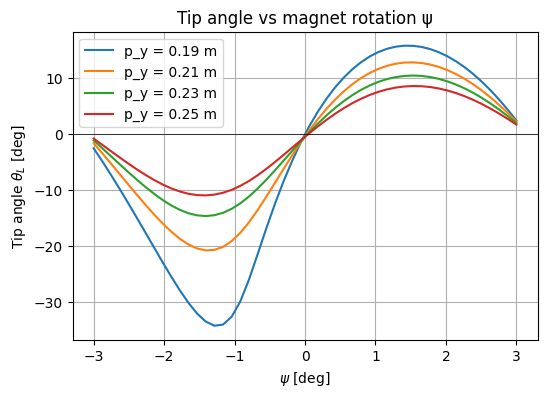

In [22]:
plt.figure(figsize=(6,4))
for p_y in ys[2:]:   # skip the first entry
    plt.plot(psi_vals_rad, theta_vs_psi[p_y], label=f"p_y = {p_y} m")

plt.axhline(0, color='k', lw=0.5)
plt.xlabel(r"$\psi$ [deg]")
plt.ylabel(r"Tip angle $\theta_L$ [deg]")
plt.legend()
plt.title("Tip angle vs magnet rotation ψ")
plt.grid(True)
plt.show()


Parsed 20 base/tip pairs


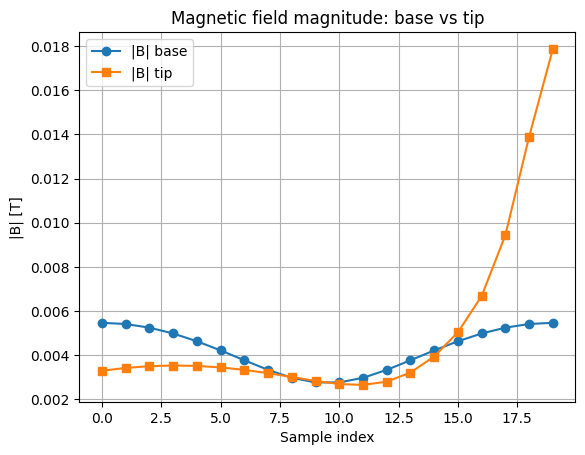

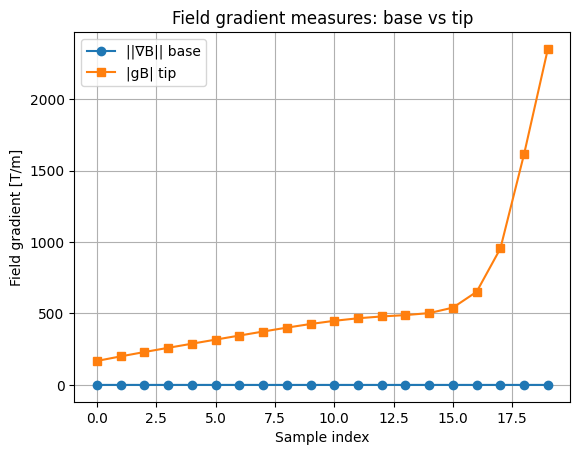

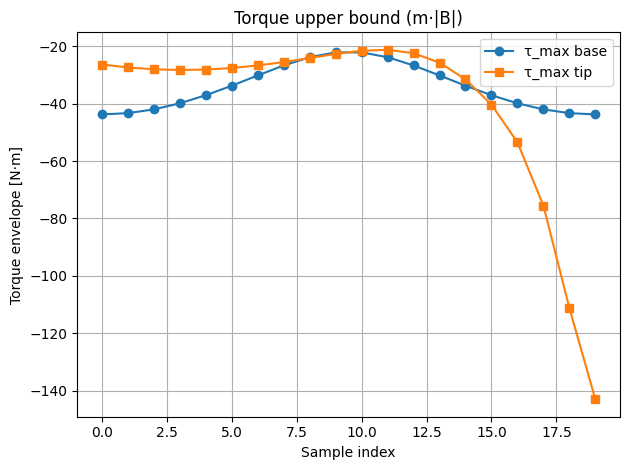

In [ ]:

raw = """
|B|_base=5.463e-03 T, ||∇B||_base=9.124e-02 T/m, m_line(0)=-8.000e+03 A·m
|B|_tip =3.288e-03 T, |gB|_tip=1.680e+02 T/m, m_line(L)=-8.000e+03 A·m
|B|_base=5.407e-03 T, ||∇B||_base=9.021e-02 T/m, m_line(0)=-8.000e+03 A·m
|B|_tip =3.416e-03 T, |gB|_tip=1.998e+02 T/m, m_line(L)=-8.000e+03 A·m
|B|_base=5.243e-03 T, ||∇B||_base=8.714e-02 T/m, m_line(0)=-8.000e+03 A·m
|B|_tip =3.496e-03 T, |gB|_tip=2.303e+02 T/m, m_line(L)=-8.000e+03 A·m
|B|_base=4.978e-03 T, ||∇B||_base=8.218e-02 T/m, m_line(0)=-8.000e+03 A·m
|B|_tip =3.526e-03 T, |gB|_tip=2.597e+02 T/m, m_line(L)=-8.000e+03 A·m
|B|_base=4.626e-03 T, ||∇B||_base=7.555e-02 T/m, m_line(0)=-8.000e+03 A·m
|B|_tip =3.507e-03 T, |gB|_tip=2.885e+02 T/m, m_line(L)=-8.000e+03 A·m
|B|_base=4.211e-03 T, ||∇B||_base=6.760e-02 T/m, m_line(0)=-8.000e+03 A·m
|B|_tip =3.440e-03 T, |gB|_tip=3.171e+02 T/m, m_line(L)=-8.000e+03 A·m
|B|_base=3.763e-03 T, ||∇B||_base=5.885e-02 T/m, m_line(0)=-8.000e+03 A·m
|B|_tip =3.329e-03 T, |gB|_tip=3.455e+02 T/m, m_line(L)=-8.000e+03 A·m
|B|_base=3.328e-03 T, ||∇B||_base=5.007e-02 T/m, m_line(0)=-8.000e+03 A·m
|B|_tip =3.180e-03 T, |gB|_tip=3.737e+02 T/m, m_line(L)=-8.000e+03 A·m
|B|_base=2.968e-03 T, ||∇B||_base=4.249e-02 T/m, m_line(0)=-8.000e+03 A·m
|B|_tip =3.006e-03 T, |gB|_tip=4.010e+02 T/m, m_line(L)=-8.000e+03 A·m
|B|_base=2.759e-03 T, ||∇B||_base=3.788e-02 T/m, m_line(0)=-8.000e+03 A·m
|B|_tip =2.827e-03 T, |gB|_tip=4.265e+02 T/m, m_line(L)=-8.000e+03 A·m
|B|_base=2.759e-03 T, ||∇B||_base=3.788e-02 T/m, m_line(0)=-8.000e+03 A·m
|B|_tip =2.686e-03 T, |gB|_tip=4.488e+02 T/m, m_line(L)=-8.000e+03 A·m
|B|_base=2.968e-03 T, ||∇B||_base=4.249e-02 T/m, m_line(0)=-8.000e+03 A·m
|B|_tip =2.646e-03 T, |gB|_tip=4.666e+02 T/m, m_line(L)=-8.000e+03 A·m
|B|_base=3.328e-03 T, ||∇B||_base=5.007e-02 T/m, m_line(0)=-8.000e+03 A·m
|B|_tip =2.794e-03 T, |gB|_tip=4.793e+02 T/m, m_line(L)=-8.000e+03 A·m
|B|_base=3.763e-03 T, ||∇B||_base=5.885e-02 T/m, m_line(0)=-8.000e+03 A·m
|B|_tip =3.207e-03 T, |gB|_tip=4.889e+02 T/m, m_line(L)=-8.000e+03 A·m
|B|_base=4.211e-03 T, ||∇B||_base=6.760e-02 T/m, m_line(0)=-8.000e+03 A·m
|B|_tip =3.934e-03 T, |gB|_tip=5.028e+02 T/m, m_line(L)=-8.000e+03 A·m
|B|_base=4.626e-03 T, ||∇B||_base=7.555e-02 T/m, m_line(0)=-8.000e+03 A·m
|B|_tip =5.034e-03 T, |gB|_tip=5.411e+02 T/m, m_line(L)=-8.000e+03 A·m
|B|_base=4.978e-03 T, ||∇B||_base=8.218e-02 T/m, m_line(0)=-8.000e+03 A·m
|B|_tip =6.677e-03 T, |gB|_tip=6.520e+02 T/m, m_line(L)=-8.000e+03 A·m
|B|_base=5.243e-03 T, ||∇B||_base=8.714e-02 T/m, m_line(0)=-8.000e+03 A·m
|B|_tip =9.440e-03 T, |gB|_tip=9.552e+02 T/m, m_line(L)=-8.000e+03 A·m
|B|_base=5.407e-03 T, ||∇B||_base=9.021e-02 T/m, m_line(0)=-8.000e+03 A·m
|B|_tip =1.390e-02 T, |gB|_tip=1.617e+03 T/m, m_line(L)=-8.000e+03 A·m
|B|_base=5.463e-03 T, ||∇B||_base=9.124e-02 T/m, m_line(0)=-8.000e+03 A·m
|B|_tip =1.788e-02 T, |gB|_tip=2.352e+03 T/m, m_line(L)=-8.000e+03 A·m
p_y=0.22: filled 20/20 points
"""

base_pat = re.compile(r"\|B\|_base=([-\deE.+]+)\s*T,\s*\|\|.?B\|\|_base=([-\deE.+]+)\s*T/m,\s*m_line\(0\)=([-\deE.+]+)")
tip_pat  = re.compile(r"\|B\|_tip\s*=([-\deE.+]+)\s*T,\s*\|gB\|_tip=([-\deE.+]+)\s*T/m,\s*m_line\(L\)=([-\deE.+]+)")

lines = [ln.strip() for ln in raw.strip().splitlines() if ln.strip()]

records = []
pending_base = None  
for ln in lines:
    mb = base_pat.search(ln)
    if mb:
        pending_base = {
            "|B|_base [T]": float(mb.group(1)),
            "||∇B||_base [T/m]": float(mb.group(2)),
            "m_line(0) [A·m]": float(mb.group(3)),
        }
        continue

    mt = tip_pat.search(ln)
    if mt and pending_base is not None:
        B_tip   = float(mt.group(1))
        gB_tip  = float(mt.group(2))
        mL      = float(mt.group(3))
        m0      = pending_base["m_line(0) [A·m]"]
        tau_base_max = m0 * pending_base["|B|_base [T]"]
        tau_tip_max  = mL * B_tip

        rec = {
            "idx": len(records),
            "|B|_tip [T]": B_tip,
            "|gB|_tip [T/m]": gB_tip,
            "m_line(L) [A·m]": mL,
            "tau_max_base [N·m]": tau_base_max,
            "tau_max_tip [N·m]": tau_tip_max,
        }
        rec.update(pending_base)
        records.append(rec)
        pending_base = None  

df = pd.DataFrame(records)
print(f"Parsed {len(df)} base/tip pairs")
if df.empty:
    raise ValueError("No records parsed — check regex patterns or line ordering.")

plt.figure()
plt.plot(df["idx"], df["|B|_base [T]"], marker="o", label="|B| base")
plt.plot(df["idx"], df["|B|_tip [T]"],  marker="s", label="|B| tip")
plt.xlabel("Sample index")
plt.ylabel("|B| [T]")
plt.legend()
plt.title("Magnetic field magnitude: base vs tip")
plt.grid(True)

plt.figure()
plt.plot(df["idx"], df["||∇B||_base [T/m]"], marker="o", label="||∇B|| base")
plt.plot(df["idx"], df["|gB|_tip [T/m]"],   marker="s", label="|gB| tip")
plt.xlabel("Sample index")
plt.ylabel("Field gradient [T/m]")
plt.legend()
plt.title("Field gradient measures: base vs tip")
plt.grid(True)

plt.figure()
plt.plot(df["idx"], df["tau_max_base [N·m]"], marker="o", label="τ_max base")
plt.plot(df["idx"], df["tau_max_tip [N·m]"],  marker="s", label="τ_max tip")
plt.xlabel("Sample index")
plt.ylabel("Torque envelope [N·m]")
plt.legend()
plt.title("Torque upper bound (m·|B|)")
plt.grid(True)

plt.tight_layout()
plt.show()


In [34]:

# psi_vals_deg = np.linspace(-90, 90, 20)
psi_vals_rad = np.linspace(-3,3,50)
# ys = np.array([0.18])   
ys = np.array([0.17, 0.19, 0.21, 0.23, 0.25])

theta_vs_psi = {py: [] for py in ys}
dtheta_dpsi_vs_psi = {py: [] for py in ys}
psi_done = {py: [] for py in ys}
packs = {py: [] for py in ys} 

for p_y in ys:
    p_vec = np.array([0.0, p_y, 0.0], float)
    for psi_rad in psi_vals_rad:
        try:
            theta_tip, J_tip, pack = jacobian_tip_from_sim2(
                p_vec, psi_rad,
                L=LENGTH, A_val=A_val, E_val=E_val, I_val=I_val,
                MU0=MU0, MAGNET_M=MAGNET_M,
                m_line_of_s=m_line_of_s,
                GRAD_SCALE=1.0, s_steps=400
            )
        except Exception as e:
            print(f"[WARN] skipped p_y={p_y}, psi={psi_rad:.1f}: {e}")
            continue

        theta_vs_psi[p_y].append(np.degrees(theta_tip))
        dtheta_dpsi_vs_psi[p_y].append(J_tip)            
        psi_done[p_y].append(psi_rad)
        packs[p_y].append(pack)

    print(f"p_y={p_y}: filled {len(psi_done[p_y])}/{len(psi_vals_rad)} points")


p_y=0.17: filled 50/50 points
p_y=0.19: filled 50/50 points
p_y=0.21: filled 50/50 points
p_y=0.23: filled 50/50 points
p_y=0.25: filled 50/50 points


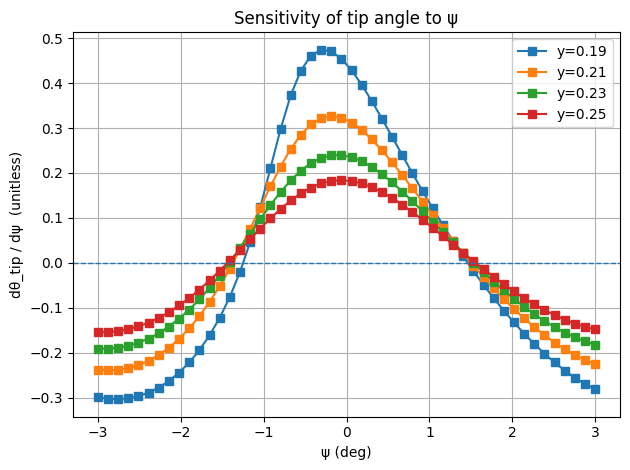

In [36]:
plt.figure()
for p_y in ys[1:]:
    ps = np.array(psi_done[p_y])
    J  = np.array(dtheta_dpsi_vs_psi[p_y])
    order = np.argsort(ps)
    plt.plot(ps[order], J[order], marker='s', label=f"y={p_y:.2f}")
plt.axhline(0, linestyle='--', linewidth=1)
plt.xlabel("ψ (deg)")
plt.ylabel("dθ_tip / dψ  (unitless)")
plt.title("Sensitivity of tip angle to ψ")
plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()


This gives an understanding of the linearised coefficients within the jacobian calculations. The a vals describe the df/dtheta values which indicate as the beam bends the magnetic torque desity decreases to meet boundary conditions

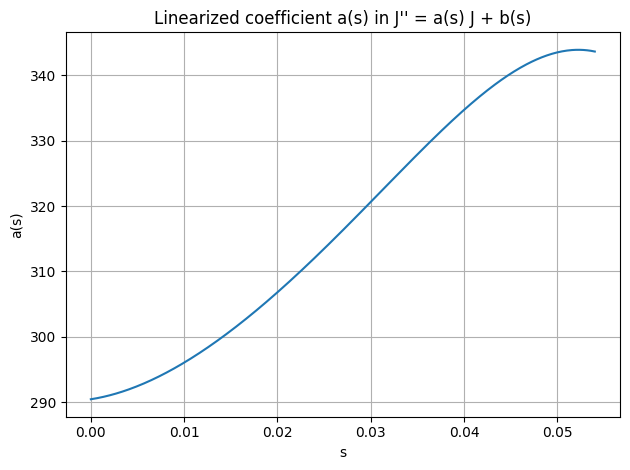

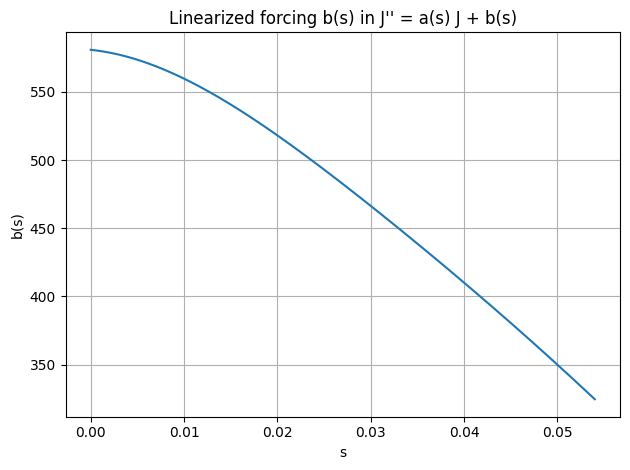

In [24]:
p_y0 = ys[0]
pack0 = packs[p_y0][-1]
s = pack0["s"]; a = pack0["a"]; b = pack0["b"]

plt.figure(); plt.plot(s, a)
plt.xlabel("s"); plt.ylabel("a(s)")
plt.title("Linearized coefficient a(s) in J'' = a(s) J + b(s)")
plt.grid(True); plt.tight_layout(); plt.show()

plt.figure(); plt.plot(s, b)
plt.xlabel("s"); plt.ylabel("b(s)")
plt.title("Linearized forcing b(s) in J'' = a(s) J + b(s)")
plt.grid(True); plt.tight_layout(); plt.show()


Here we provide an analysis of the linearised cofficients. This shows the change of torque on the beam with respect to theta and psi. When in attractive mode the sensitivity on the beam at the tip with respect to both theta and psi is highest, which is the not comparable when in repulsion mode. This offers intuition into the senstivity and control of the beam.

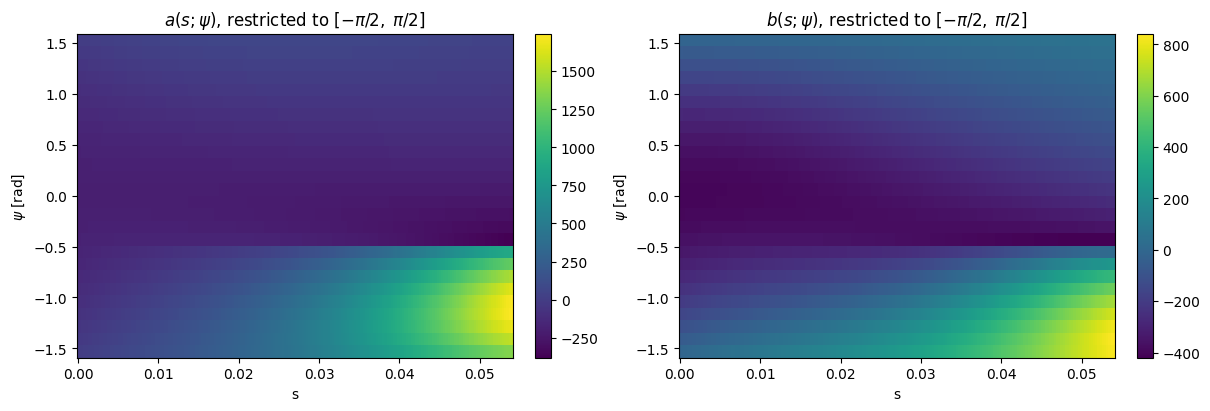

In [ ]:
p_y0 = ys[0]                   
packs0 = packs[p_y0]             
psi_grid = np.array(psi_done[p_y0])

s_common = np.linspace(0, LENGTH, 200)
A_map = np.zeros((len(psi_grid), len(s_common)))
B_map = np.zeros_like(A_map)

for i, pack in enumerate(packs0):
    s_i = pack["s"]
    a_i = pack["a"]
    b_i = pack["b"]
    A_map[i,:] = np.interp(s_common, s_i, a_i)
    B_map[i,:] = np.interp(s_common, s_i, b_i)

mask = (psi_grid >= -np.pi/2) & (psi_grid <= np.pi/2)

psi_sel = psi_grid[mask]
A_sel   = A_map[mask, :]
B_sel   = B_map[mask, :]

fig, axs = plt.subplots(1,2, figsize=(12,4), constrained_layout=True)

hm1 = axs[0].pcolormesh(s_common, psi_sel, A_sel, shading="auto")
axs[0].set_title(r"$a(s;\psi)$, restricted to $[-\pi/2,\;\pi/2]$")
axs[0].set_xlabel("s"); axs[0].set_ylabel(r"$\psi$ [rad]")
plt.colorbar(hm1, ax=axs[0])

hm2 = axs[1].pcolormesh(s_common, psi_sel, B_sel, shading="auto")
axs[1].set_title(r"$b(s;\psi)$, restricted to $[-\pi/2,\;\pi/2]$")
axs[1].set_xlabel("s"); axs[1].set_ylabel(r"$\psi$ [rad]")
plt.colorbar(hm2, ax=axs[1])

plt.show()



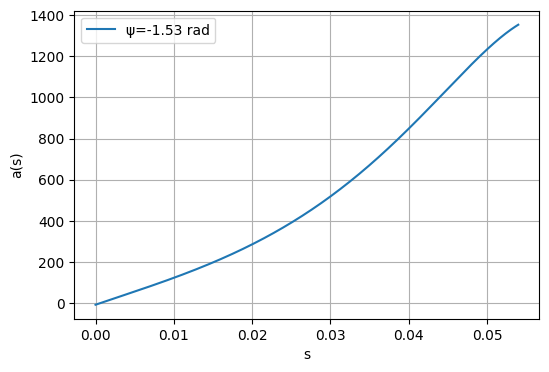

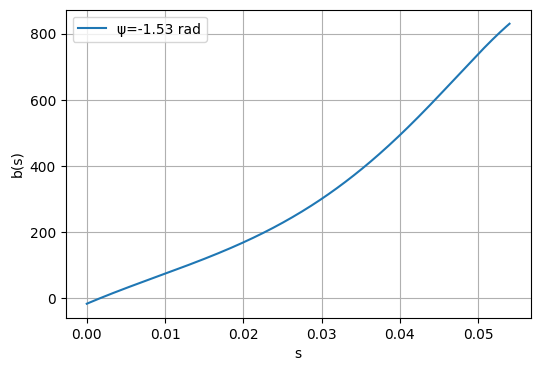

In [ ]:
plt.figure(figsize=(6,4))
for idx in [len(packs0)//4]:   
    pack = packs0[idx]
    plt.plot(pack["s"], pack["a"], label=f"ψ={psi_grid[idx]:.2f} rad")
plt.xlabel("s"); plt.ylabel("a(s)"); plt.grid(True); plt.legend(); plt.show()

plt.figure(figsize=(6,4))
for idx in [len(packs0)//4]:
    pack = packs0[idx]
    plt.plot(pack["s"], pack["b"], label=f"ψ={psi_grid[idx]:.2f} rad")
plt.xlabel("s"); plt.ylabel("b(s)"); plt.grid(True); plt.legend(); plt.show()


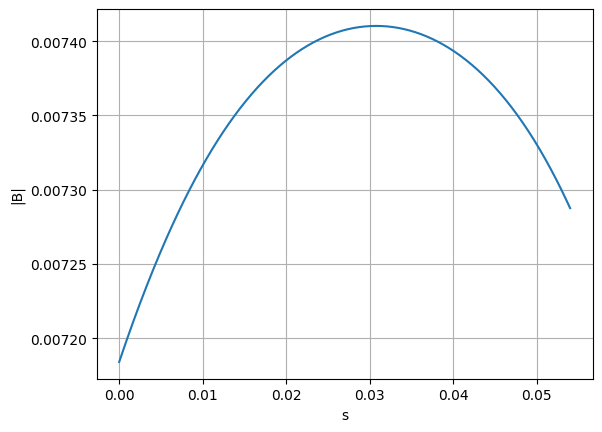

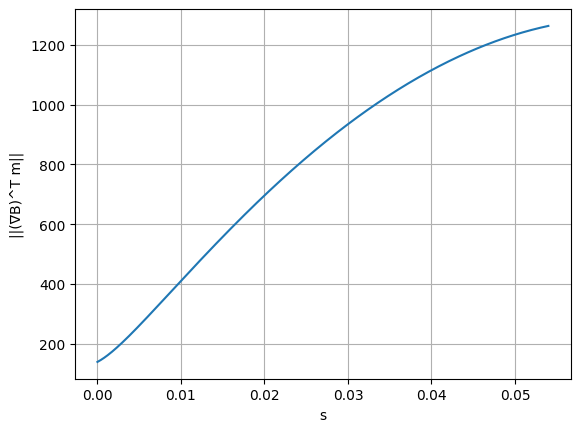

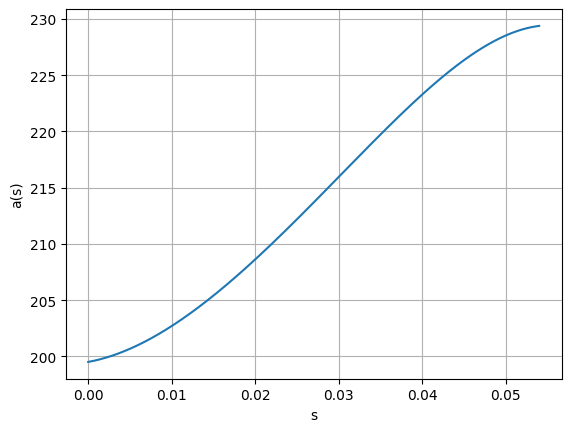

In [ ]:
pack = packs[p_y0][i]  
s = pack["s"]
B = pack.get("B_path")       
gB = pack.get("gB_path")        
plt.figure(); plt.plot(s, np.linalg.norm(B, axis=1)); plt.ylabel('|B|'); plt.xlabel('s'); plt.grid(); plt.show()
plt.figure(); plt.plot(s, np.linalg.norm(gB, axis=1)); plt.ylabel('||(∇B)^T m||'); plt.xlabel('s'); plt.grid(); plt.show()
plt.figure(); plt.plot(s, pack["a"]); plt.ylabel('a(s)'); plt.xlabel('s'); plt.grid(); plt.show()
